# BigARTM Python API.

BigARTM --- открытая библиотека для тематического моделирования текстовых коллекций, реализующая теорию аддитивной регуляризации тематических моделей (ARTM). Основной сайт проекта http://bigartm.org/.

Здесь показан пример использования пользовательского Python API библиотеки. Мы проведём демонстрационный эксперимент.

####Описание:
Построим две тематические модели коллекции текстовых документов, ARTM и PLSA, сравним качество полученных моделей.

####Функционалы качества:
Важным функционалом является перплексия коллекции. Тем не менее, это далеко не единственная величина, характеризующая качество обучения. В BigARTM реализованы следующие функционалы:

- разреженность матрицы $\Phi$ (слова-темы);
- разреженность матрицы $\Theta$ (темы-документы);
- характеристики ядер тем (чистота, контрастность, размер);
- перплексия;
- когерентность топ-слов и слов из ядер тем.

Мы будем использовать первые четыре. Более сильные разреженности матриц и более высокие средние значения чистоты и контрастности способствуют большей интерпретируемости модели.

####Цель эксперимента:
Попробуем обучить модель ARTM таким образом, чтобы, в сравнении с PLSA, улучшить значения разреженностей и ядровых характеристик и не сильно ухудшить перплексию.

Основным инструментом для корректирования процесса обучения являются регуляризаторы. Список имеющихся в BigARTM регуляризаторов:

- разреживание матрицы $\Phi$ (+ частичное обучение);
- разреживание матрицы $\Theta$ (+ частичное обучение);
- декоррелирование тем в матрице $\Phi$;
- принудительное разреживания $\Phi$;
- балансирование классов (Label Regularization);
- повышение когерентности.

В этом эксперименте для обучения ARTM воспользуемся первыми тремя регуляризаторами. ARTM без регуляризации соответствует PLSA.

####Коллекция:
Воспользуемся небольшой коллекцией 'kos', доступной в репозитории UCI https://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/. Параметры коллекции следующие:

- 3430 документов;
- 6906 слов в словаре;
- 467714 слов в коллекции.

Для начала подключим все необходимые модули (убедитесь, что путь к Python API BigARTM находится в вашей переменной PATH):

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt

import artm

Прежде всего необходимо подготовить входные данные. BigARTM имеет собственный формат документов для обработки, называемый батчами. В библиотеки присутствуют средства по созданию батчей из файлов Bag-Of-Words в форматах UCI и Vowpal Wabbit (подробности можно найти в http://docs.bigartm.org/en/latest/formats.html).

В Python API, по аналогии с алгоритмами из scikit-learn, входные данные представлены одним классом BatchVectorizer. Объект этого класса принимает на вход батчи или файлы с Bag-Of-Words и подаётся на вход всем методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

Итак, создадим объект BatchVectorizer:

In [2]:
batch_vectorizer = None
if len(glob.glob('kos' + "/*.batch")) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci', collection_name='kos', target_folder='kos')
else:
    batch_vectorizer = artm.BatchVectorizer(data_path='kos', data_format='batches')

ARTM --- это класс, представляющий собой Python API BigARTM, и позволяющий использовать практически все возможности библиотеки в стиле scikit-learn. Создадим две тематические модели для нашего эксперимента. Наиболее важными параметрами моделей являются число тем и число проходов по документам коллекции в процессе итераций ЕМ-алгоритма. Опционально можно указать списки регуляризаторов и функционалов качества, которые следует использовать для данной модели. Если этого не сделать, то регуляризаторы и функционалы всегда можно добавить позднее. Обратите внимание, что каждая модель задаёт своё пространство имён для названий регуляризаторов и функционалов качества.

In [3]:
model_plsa = artm.ARTM(num_topics=15,
                  scores=[artm.PerplexityScore(name='PerplexityScore',
                                               use_unigram_document_model=False,
                                               dictionary_name='dictionary')])

model_artm = artm.ARTM(num_topics=15,
                  scores=[artm.PerplexityScore(name='PerplexityScore',
                                               use_unigram_document_model=False,
                                               dictionary_name='dictionary')],
                  regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5)])

Следующий шаг — инициализация моделей. Сделаем это по словарю, что означает, что
- будет создана матрица $\Phi$ с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эа матрица будет заполнена случайными значениями из диапазона (0, 1) и нормализована.

Надо отметить, что этот шаг является опциональным, поскольку модель может быть автоматически инициализирована во время вызовов fit_offline() / fit_online().

Словарь --- это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.

In [5]:
model_plsa.gather_dictionary("dictionary", batch_vectorizer.data_path)
model_plsa.save_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary.dict')
model_artm.load_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary.dict')

Затем словари можн оиспользовать, чтобы инициализировать модель:

In [6]:
model_plsa.initialize(dictionary_name='dictionary')
model_artm.initialize(dictionary_name='dictionary')

Как уже было сказано, ARTM предоставляет возможность использовать все функционалы качества, имеющиеся в BigARTM. Если функционал подключен к модели, то модель будет сохранять все его значения, полученные на момент каждого обновления матрицы $\Phi$. Добавим функционалы качества, нужные для нашего эксперимента, которые отсутствовали в конструкторах:

In [7]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

Аналогично поступим с регуляризаторами для model_artm (зададим им стартовые коэффициенты регуляризации, которые можно будет позже изменить при необходимости):

In [8]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.3))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2e+5))

Теперь попробуем обучить модели в оффлайн-режиме (т.е. обновляя Фи раз за проход по коллекции). Инициируем пять проходов:

In [9]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

Проверим результаты первой итерации обучения, сравнив финальные значения функционалов, а также графики перплексии (опишем печать в виде функции для возможности повторного использования):

Sparsity Phi: 0.000 (PLSA) vs. 0.359 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.048 (ARTM)
Kernel contrast: 0.367 (PLSA) vs. 0.415 (ARTM)
Kernel purity: 0.009 (PLSA) vs. 0.076 (ARTM)
Perplexity: 2459.115 (PLSA) vs. 2680.900 (ARTM)


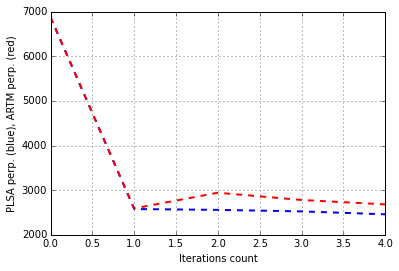

In [10]:
def print_measures(model_plsa, model_artm):
    print 'Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value)

    print 'Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value)

    print 'Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast)

    print 'Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity)

    print 'Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value)

    plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             xrange(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_artm)

Видно, что улучшения разреженностей и ядровых характеристик есть, а ухудшение перплексии невелико. Попробуем увеличить по модулю значения коэффициентов регуляризации при регуляризаторах:

In [11]:
model_artm.regularizers['SparsePhi'].tau = -1.2
model_artm.regularizers['SparseTheta'].tau = -0.6
model_artm.regularizers['DecorrelatorPhi'].tau = 4.5e+5

Кроме того, подключим к каждой из моделей функционал TopTokensScore, который позволит взглянуть на самые вероятные слова в каждой теме:

In [12]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

Продолжим обучение моделей, инициировав 15 проходов по коллекции, после чего снова посмотрим на значения функционалов качества:

In [13]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Sparsity Phi: 0.086 (PLSA) vs. 0.833 (ARTM)
Sparsity Theta: 0.001 (PLSA) vs. 0.483 (ARTM)
Kernel contrast: 0.527 (PLSA) vs. 0.677 (ARTM)
Kernel purity: 0.395 (PLSA) vs. 0.670 (ARTM)
Perplexity: 1437.567 (PLSA) vs. 1910.173 (ARTM)


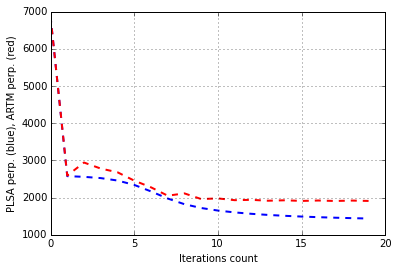

In [14]:
print_measures(model_plsa, model_artm)

Кроме того, для наглядности построим графики изменения разреженностей матриц по итерациям:

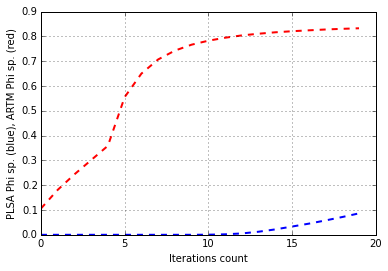

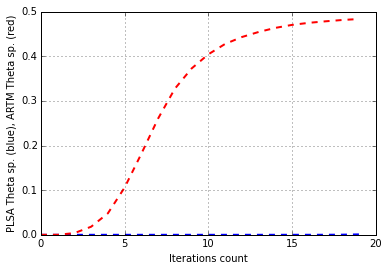

In [15]:
plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

Кажется, что достигнутых результатов достаточно. Регуляризация позволила добиться улучшения всех характеристик, ухудшив перплексию в пределах разумного. Взглянем на топ-слова слова моделей:

In [16]:
for topic_name in model_plsa.topic_names:
    print topic_name + ': ',
    print model_plsa.score_tracker['TopTokensScore'].last_topic_info[topic_name].tokens

@topic_0:  [u'bush', u'party', u'tax', u'president', u'political', u'court']
@topic_1:  [u'iraq', u'war', u'military', u'troops', u'killed', u'people']
@topic_2:  [u'november', u'poll', u'governor', u'house', u'electoral', u'account']
@topic_3:  [u'senate', u'republican', u'gop', u'race', u'campaign', u'republicans']
@topic_4:  [u'election', u'general', u'time', u'specter', u'people', u'bush']
@topic_5:  [u'kerry', u'dean', u'edwards', u'clark', u'primary', u'democratic']
@topic_6:  [u'state', u'race', u'democrats', u'party', u'candidates', u'democratic']
@topic_7:  [u'administration', u'bush', u'president', u'years', u'house', u'bill']
@topic_8:  [u'campaign', u'dean', u'democratic', u'media', u'iowa', u'states']
@topic_9:  [u'house', u'republican', u'million', u'money', u'delay', u'committee']
@topic_10:  [u'november', u'vote', u'voting', u'kerry', u'senate', u'house']
@topic_11:  [u'iraq', u'bush', u'war', u'administration', u'president', u'american']
@topic_12:  [u'bush', u'poll', 

In [17]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print model_artm.score_tracker['TopTokensScore'].last_topic_info[topic_name].tokens

@topic_0:  [u'party', u'tax', u'political', u'court', u'issue', u'law']
@topic_1:  [u'military', u'troops', u'killed', u'officials', u'attacks', u'service']
@topic_2:  [u'account', u'electoral', u'governor', u'contact', u'sunzoo', u'experience']
@topic_3:  [u'republican', u'senate', u'gop', u'debate', u'senator', u'carson']
@topic_4:  [u'specter', u'toomey', u'workers', u'oil', u'signs', u'yesterday']
@topic_5:  [u'dean', u'edwards', u'clark', u'john', u'gephardt', u'iowa']
@topic_6:  [u'state', u'democrats', u'candidates', u'race', u'party', u'candidate']
@topic_7:  [u'administration', u'years', u'white', u'president', u'bill', u'jobs']
@topic_8:  [u'campaign', u'media', u'union', u'national', u'ads', u'press']
@topic_9:  [u'house', u'republican', u'million', u'elections', u'delay', u'committee']
@topic_10:  [u'kerry', u'november', u'general', u'vote', u'poll', u'primary']
@topic_11:  [u'iraq', u'war', u'american', u'iraqi', u'administration', u'people']
@topic_12:  [u'percent', u'pol

Видно, что темы примерно одинаково интерпретируемы, но в модели ARTM они существенно разнообразнее.

Извлечём матрицу $\Phi$ в виде pandas.DataFrame и напечатаем её (в случае необходимости, можно извлекать части матрицы с помощью метода ARTM.get_phi()):

In [18]:
print model_artm.phi_

             @topic_0  @topic_1  @topic_2  @topic_3  @topic_4  @topic_5  \
children     0.001205  0.002633         0  0.000005  0.002304  0.000000   
felt         0.000840  0.000041         0  0.000000  0.000000  0.000417   
armstrong    0.000000  0.000206         0  0.000400  0.000000  0.001676   
bush         0.000000  0.000000         0  0.000000  0.000000  0.000000   
effect       0.000375  0.000000         0  0.000171  0.001188  0.001199   
costs        0.001567  0.000500         0  0.000000  0.000000  0.000166   
preview      0.000000  0.000000         0  0.000517  0.000000  0.000000   
objective    0.000000  0.000119         0  0.000000  0.000884  0.000000   
ads          0.000000  0.000000         0  0.002820  0.000000  0.000057   
broad        0.000000  0.000583         0  0.000154  0.000000  0.000000   
polled       0.000000  0.000000         0  0.000000  0.000000  0.000000   
serve        0.000000  0.000000         0  0.000097  0.000000  0.000728   
famous       0.000000  0.

Модель можно сохранить с возможностью последующей загрузки:

In [19]:
model_artm.save(filename='kos_artm_model')  # save the model to disk

# model = artm.ARTM(...)                    # create new model
# model.load(filename='kos_artm_model')     # load saved model into new instance

Дополнительно извлечём $\Theta$ в виде pandas.DataFrame и напечатаем её:

In [20]:
theta_matrix = model_artm.fit_transform()
print theta_matrix

               2001      2002      2003      2004      2005      2006  \
@topic_0   0.110953  0.067653  0.000000  0.000000  0.000000  0.000000   
@topic_1   0.000000  0.000000  0.000000  0.048701  0.000000  0.000000   
@topic_2   0.000000  0.000000  0.000000  0.000000  0.000000  0.737427   
@topic_3   0.253281  0.000000  0.000000  0.003071  0.000000  0.000000   
@topic_4   0.000000  0.000000  0.000000  0.083544  0.000000  0.000000   
@topic_5   0.143262  0.000000  0.291949  0.025693  0.319195  0.000000   
@topic_6   0.081114  0.407219  0.216074  0.059110  0.177984  0.000000   
@topic_7   0.000000  0.000000  0.000000  0.098996  0.000000  0.000000   
@topic_8   0.099250  0.256102  0.190394  0.035146  0.000000  0.000000   
@topic_9   0.262157  0.038052  0.000000  0.249853  0.000000  0.000000   
@topic_10  0.036377  0.044992  0.301582  0.000000  0.210815  0.262573   
@topic_11  0.000000  0.000000  0.000000  0.134788  0.000000  0.000000   
@topic_12  0.000000  0.185982  0.000000  0.078761  

Можно использовать модель для определения векторов $\theta_d$ для новых документов с помощью метода ARTM.transform():

In [21]:
test_batch_vectorizer = artm.BatchVectorizer(data_format='batches', data_path='kos_test', batches=['test_docs.batch'])
test_theta_matrix = model_artm.transform(batch_vectorizer=test_batch_vectorizer)
print test_theta_matrix

Empty DataFrame
Columns: []
Index: []


#### Выводы

Задача построения тематической модели имеет бесконечно большое множество решений. Это даёт большую свободу действий, и регуляризаторы позволяют использовать её для получения результата, удовлетворяющего сразу нескольким требованиям (разреженность, интерпретируемость, удовлетворительное значение перплексии и т.п.).

Приведённый выше пример является демонстрационным, можно пробовать более гибкие стратегии регуляризации для получения ещё более хорошего результата. По аналогичной схеме можно производить эксперименты с более крупными коллекциями.